# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 17            
model_seed = 7           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

In [4]:
# Show the names of all parameters first (helps you locate layers)
print("=== Model Parameters ===")
for name, param in model_template.named_parameters():
    print(name, param.shape)

# Example: print first few weights from the first layer
first_layer_weights = next(model_template.parameters()).data
print("\n=== First layer weights (sample) ===")
print(first_layer_weights[:5, :5])  # first 5 rows, first 5 cols

# Example: print biases if available
for name, param in model_template.named_parameters():
    if "bias" in name:
        print(f"\n{name} (first 5 values):")
        print(param.data[:5])
        break

=== Model Parameters ===
model.0.weight torch.Size([32, 2])
model.0.bias torch.Size([32])
model.2.weight torch.Size([32, 32])
model.2.bias torch.Size([32])
model.4.weight torch.Size([32, 32])
model.4.bias torch.Size([32])
model.6.weight torch.Size([32, 32])
model.6.bias torch.Size([32])
model.8.weight torch.Size([32, 32])
model.8.bias torch.Size([32])
model.10.weight torch.Size([1, 32])
model.10.bias torch.Size([1])

=== First layer weights (sample) ===
tensor([[ 0.0494, -0.4260],
        [ 0.2252,  0.2219],
        [-0.3779, -0.1060],
        [-0.4142,  0.1835],
        [-0.1905,  0.4968]], device='cuda:0')

model.0.bias (first 5 values):
tensor([-0.2397,  0.0277, -0.4035, -0.3088,  0.2375], device='cuda:0')


## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [5]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_losses, train_other_metrics, test_losses, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6955 | Test Loss 0.6908 | accs Train 0.4725 Test 0.5787


Epoch 100/2000: Train Loss 0.5569 | Test Loss 0.5840 | accs Train 0.6400 Test 0.6230


Epoch 200/2000: Train Loss 0.0335 | Test Loss 0.0341 | accs Train 0.9975 Test 0.9952


Epoch 300/2000: Train Loss 0.0037 | Test Loss 0.0072 | accs Train 1.0000 Test 0.9982


Epoch 400/2000: Train Loss 0.0010 | Test Loss 0.0056 | accs Train 1.0000 Test 0.9985


Epoch 500/2000: Train Loss 0.0004 | Test Loss 0.0050 | accs Train 1.0000 Test 0.9985


Epoch 600/2000: Train Loss 0.0002 | Test Loss 0.0042 | accs Train 1.0000 Test 0.9985


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0039 | accs Train 1.0000 Test 0.9985


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0037 | accs Train 1.0000 Test 0.9982


Epoch 900/2000: Train Loss 0.0001 | Test Loss 0.0037 | accs Train 1.0000 Test 0.9982


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 0.0036 | accs Train 1.0000 Test 0.9982


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 0.0036 | accs Train 1.0000 Test 0.9982


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0035 | accs Train 1.0000 Test 0.9985


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0034 | accs Train 1.0000 Test 0.9985


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0033 | accs Train 1.0000 Test 0.9985


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0030 | accs Train 1.0000 Test 0.9985


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0029 | accs Train 1.0000 Test 0.9988


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0030 | accs Train 1.0000 Test 0.9990


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0030 | accs Train 1.0000 Test 0.9990


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0029 | accs Train 1.0000 Test 0.9992


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0030 | accs Train 1.0000 Test 0.9992
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6955 | Test Loss 0.6909 | accs Train 0.4732 Test 0.5813


Epoch 100/2000: Train Loss 0.5670 | Test Loss 0.5834 | accs Train 0.6366 Test 0.6238


Epoch 200/2000: Train Loss 0.1071 | Test Loss 0.0693 | accs Train 0.9756 Test 0.9930


Epoch 300/2000: Train Loss 0.0515 | Test Loss 0.0396 | accs Train 0.9805 Test 0.9910


Epoch 400/2000: Train Loss 0.0374 | Test Loss 0.0420 | accs Train 0.9854 Test 0.9885


Epoch 500/2000: Train Loss 0.0303 | Test Loss 0.0519 | accs Train 0.9878 Test 0.9825


Epoch 600/2000: Train Loss 0.0233 | Test Loss 0.0597 | accs Train 0.9951 Test 0.9802


Epoch 700/2000: Train Loss 0.0198 | Test Loss 0.0621 | accs Train 0.9976 Test 0.9795


Epoch 800/2000: Train Loss 0.0172 | Test Loss 0.0717 | accs Train 0.9951 Test 0.9750


Epoch 900/2000: Train Loss 0.0159 | Test Loss 0.0818 | accs Train 0.9951 Test 0.9742


Epoch 1000/2000: Train Loss 0.0142 | Test Loss 0.0851 | accs Train 0.9976 Test 0.9722


Epoch 1100/2000: Train Loss 0.0130 | Test Loss 0.0892 | accs Train 0.9976 Test 0.9730


Epoch 1200/2000: Train Loss 0.0132 | Test Loss 0.1065 | accs Train 0.9951 Test 0.9688


Epoch 1300/2000: Train Loss 0.0178 | Test Loss 0.0685 | accs Train 0.9951 Test 0.9748


Epoch 1400/2000: Train Loss 0.0160 | Test Loss 0.0644 | accs Train 0.9951 Test 0.9750


Epoch 1500/2000: Train Loss 0.0149 | Test Loss 0.0632 | accs Train 0.9951 Test 0.9752


Epoch 1600/2000: Train Loss 0.0142 | Test Loss 0.0620 | accs Train 0.9951 Test 0.9762


Epoch 1700/2000: Train Loss 0.0135 | Test Loss 0.0620 | accs Train 0.9951 Test 0.9768


Epoch 1800/2000: Train Loss 0.0130 | Test Loss 0.0624 | accs Train 0.9951 Test 0.9775


Epoch 1900/2000: Train Loss 0.0127 | Test Loss 0.0640 | accs Train 0.9951 Test 0.9765


Epoch 2000/2000: Train Loss 0.0123 | Test Loss 0.0652 | accs Train 0.9951 Test 0.9762
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6953 | Test Loss 0.6910 | accs Train 0.4762 Test 0.5837


Epoch 100/2000: Train Loss 0.5694 | Test Loss 0.5688 | accs Train 0.6381 Test 0.6312


Epoch 200/2000: Train Loss 0.1629 | Test Loss 0.0887 | accs Train 0.9524 Test 0.9868


Epoch 300/2000: Train Loss 0.1187 | Test Loss 0.0673 | accs Train 0.9595 Test 0.9855


Epoch 400/2000: Train Loss 0.0943 | Test Loss 0.0641 | accs Train 0.9595 Test 0.9808


Epoch 500/2000: Train Loss 0.0803 | Test Loss 0.0787 | accs Train 0.9690 Test 0.9738


Epoch 600/2000: Train Loss 0.0740 | Test Loss 0.0906 | accs Train 0.9714 Test 0.9712


Epoch 700/2000: Train Loss 0.0673 | Test Loss 0.0885 | accs Train 0.9714 Test 0.9735


Epoch 800/2000: Train Loss 0.0633 | Test Loss 0.0945 | accs Train 0.9714 Test 0.9712


Epoch 900/2000: Train Loss 0.0609 | Test Loss 0.0962 | accs Train 0.9738 Test 0.9710


Epoch 1000/2000: Train Loss 0.0607 | Test Loss 0.0974 | accs Train 0.9762 Test 0.9667


Epoch 1100/2000: Train Loss 0.0638 | Test Loss 0.0851 | accs Train 0.9714 Test 0.9732


Epoch 1200/2000: Train Loss 0.0602 | Test Loss 0.0946 | accs Train 0.9714 Test 0.9708


Epoch 1300/2000: Train Loss 0.0579 | Test Loss 0.0989 | accs Train 0.9738 Test 0.9680


Epoch 1400/2000: Train Loss 0.0566 | Test Loss 0.1036 | accs Train 0.9738 Test 0.9690


Epoch 1500/2000: Train Loss 0.0555 | Test Loss 0.1088 | accs Train 0.9738 Test 0.9660


Epoch 1600/2000: Train Loss 0.0546 | Test Loss 0.1107 | accs Train 0.9762 Test 0.9667


Epoch 1700/2000: Train Loss 0.0550 | Test Loss 0.1127 | accs Train 0.9810 Test 0.9663


Epoch 1800/2000: Train Loss 0.0538 | Test Loss 0.1124 | accs Train 0.9810 Test 0.9663


Epoch 1900/2000: Train Loss 0.0723 | Test Loss 0.2245 | accs Train 0.9738 Test 0.9327


Epoch 2000/2000: Train Loss 0.0526 | Test Loss 0.1123 | accs Train 0.9786 Test 0.9670
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6951 | Test Loss 0.6911 | accs Train 0.4867 Test 0.5680


Epoch 100/2000: Train Loss 0.5987 | Test Loss 0.5955 | accs Train 0.6489 Test 0.6390


Epoch 200/2000: Train Loss 0.2929 | Test Loss 0.1869 | accs Train 0.8978 Test 0.9653


Epoch 300/2000: Train Loss 0.2380 | Test Loss 0.1365 | accs Train 0.9067 Test 0.9700


Epoch 400/2000: Train Loss 0.2165 | Test Loss 0.1405 | accs Train 0.9111 Test 0.9585


Epoch 500/2000: Train Loss 0.2042 | Test Loss 0.1493 | accs Train 0.9156 Test 0.9535


Epoch 600/2000: Train Loss 0.1917 | Test Loss 0.1562 | accs Train 0.9244 Test 0.9477


Epoch 700/2000: Train Loss 0.1841 | Test Loss 0.1726 | accs Train 0.9244 Test 0.9363


Epoch 800/2000: Train Loss 0.1780 | Test Loss 0.1578 | accs Train 0.9267 Test 0.9490


Epoch 900/2000: Train Loss 0.1722 | Test Loss 0.1730 | accs Train 0.9267 Test 0.9413


Epoch 1000/2000: Train Loss 0.1721 | Test Loss 0.1754 | accs Train 0.9289 Test 0.9383


Epoch 1100/2000: Train Loss 0.1642 | Test Loss 0.1791 | accs Train 0.9311 Test 0.9387


Epoch 1200/2000: Train Loss 0.1597 | Test Loss 0.1779 | accs Train 0.9289 Test 0.9445


Epoch 1300/2000: Train Loss 0.1614 | Test Loss 0.1830 | accs Train 0.9267 Test 0.9417


Epoch 1400/2000: Train Loss 0.1517 | Test Loss 0.1923 | accs Train 0.9289 Test 0.9370


Epoch 1500/2000: Train Loss 0.1522 | Test Loss 0.2125 | accs Train 0.9356 Test 0.9233


Epoch 1600/2000: Train Loss 0.1519 | Test Loss 0.2203 | accs Train 0.9356 Test 0.9210


Epoch 1700/2000: Train Loss 0.1458 | Test Loss 0.1982 | accs Train 0.9289 Test 0.9390


Epoch 1800/2000: Train Loss 0.1420 | Test Loss 0.2057 | accs Train 0.9333 Test 0.9367


Epoch 1900/2000: Train Loss 0.1401 | Test Loss 0.2225 | accs Train 0.9356 Test 0.9270


Epoch 2000/2000: Train Loss 0.1412 | Test Loss 0.2515 | accs Train 0.9378 Test 0.9165
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6948 | Test Loss 0.6909 | accs Train 0.4920 Test 0.5700


Epoch 100/2000: Train Loss 0.6231 | Test Loss 0.6029 | accs Train 0.6400 Test 0.6545


Epoch 200/2000: Train Loss 0.4556 | Test Loss 0.3024 | accs Train 0.7940 Test 0.9310


Epoch 300/2000: Train Loss 0.4133 | Test Loss 0.2484 | accs Train 0.8240 Test 0.9467


Epoch 400/2000: Train Loss 0.3806 | Test Loss 0.2476 | accs Train 0.8360 Test 0.9307


Epoch 500/2000: Train Loss 0.3626 | Test Loss 0.2457 | accs Train 0.8380 Test 0.9323


Epoch 600/2000: Train Loss 0.3478 | Test Loss 0.2586 | accs Train 0.8420 Test 0.9253


Epoch 700/2000: Train Loss 0.3342 | Test Loss 0.2782 | accs Train 0.8520 Test 0.9117


Epoch 800/2000: Train Loss 0.3227 | Test Loss 0.2806 | accs Train 0.8580 Test 0.9103


Epoch 900/2000: Train Loss 0.3144 | Test Loss 0.2875 | accs Train 0.8560 Test 0.9083


Epoch 1000/2000: Train Loss 0.3060 | Test Loss 0.2924 | accs Train 0.8580 Test 0.9073


Epoch 1100/2000: Train Loss 0.3070 | Test Loss 0.3172 | accs Train 0.8620 Test 0.8978


Epoch 1200/2000: Train Loss 0.2968 | Test Loss 0.3117 | accs Train 0.8760 Test 0.9008


Epoch 1300/2000: Train Loss 0.2923 | Test Loss 0.3196 | accs Train 0.8640 Test 0.8980


Epoch 1400/2000: Train Loss 0.2845 | Test Loss 0.3273 | accs Train 0.8720 Test 0.8980


Epoch 1500/2000: Train Loss 0.2878 | Test Loss 0.3508 | accs Train 0.8680 Test 0.8922


Epoch 1600/2000: Train Loss 0.2762 | Test Loss 0.3410 | accs Train 0.8740 Test 0.8945


Epoch 1700/2000: Train Loss 0.2722 | Test Loss 0.3600 | accs Train 0.8800 Test 0.8900


Epoch 1800/2000: Train Loss 0.2812 | Test Loss 0.3776 | accs Train 0.8700 Test 0.8848


Epoch 1900/2000: Train Loss 0.2685 | Test Loss 0.3767 | accs Train 0.8840 Test 0.8865


Epoch 2000/2000: Train Loss 0.2657 | Test Loss 0.3887 | accs Train 0.8820 Test 0.8820
Completed training with 100 additional samples of poison


## Training Summary

In [6]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0030 | accs: 0.9992
  10 samples | Test Loss: 0.0652 | accs: 0.9762
  20 samples | Test Loss: 0.1123 | accs: 0.9670
  50 samples | Test Loss: 0.2515 | accs: 0.9165
 100 samples | Test Loss: 0.3887 | accs: 0.8820

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0051 | accs: 1.0000
 Model   20 | Train Loss: 0.0214 | accs: 0.9975
 Model   50 | Train Loss: 0.0777 | accs: 0.9825
 Model  100 | Train Loss: 0.1439 | accs: 0.9650

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3844 | accs: 0.9756
 Model   10 | Train Loss: 0.0123 | accs: 0.9951
 Model   20 | Train Loss: 0.0320 | accs: 0.9902
 Model   50 | Train Loss: 0.0909 | accs: 0.9756
 Model  100 | Train Loss: 0.1512 | accs: 0.9610

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.7024 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

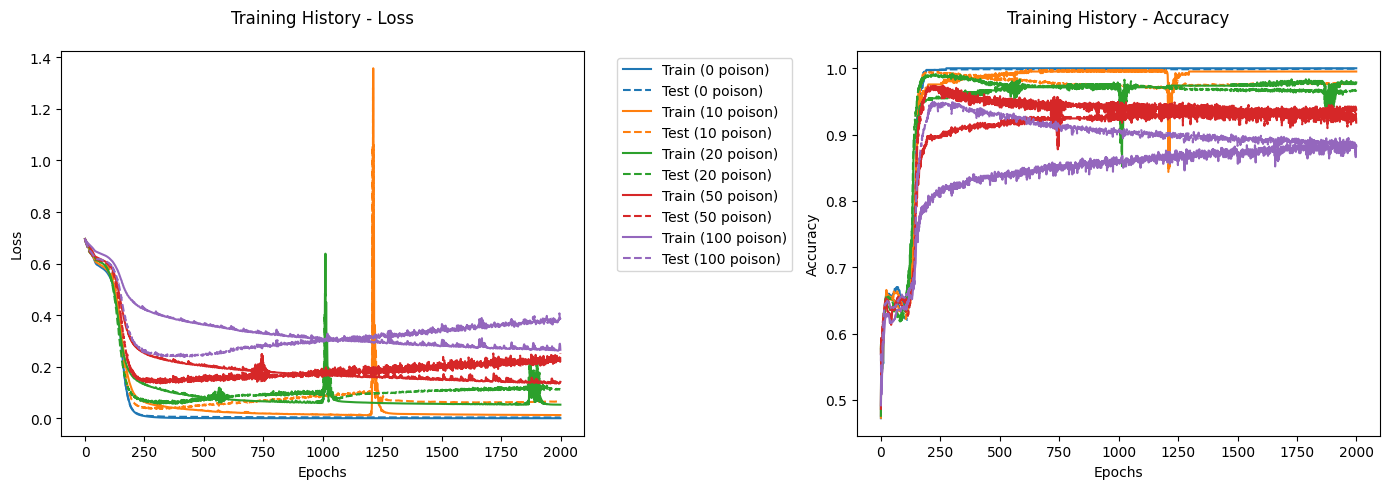

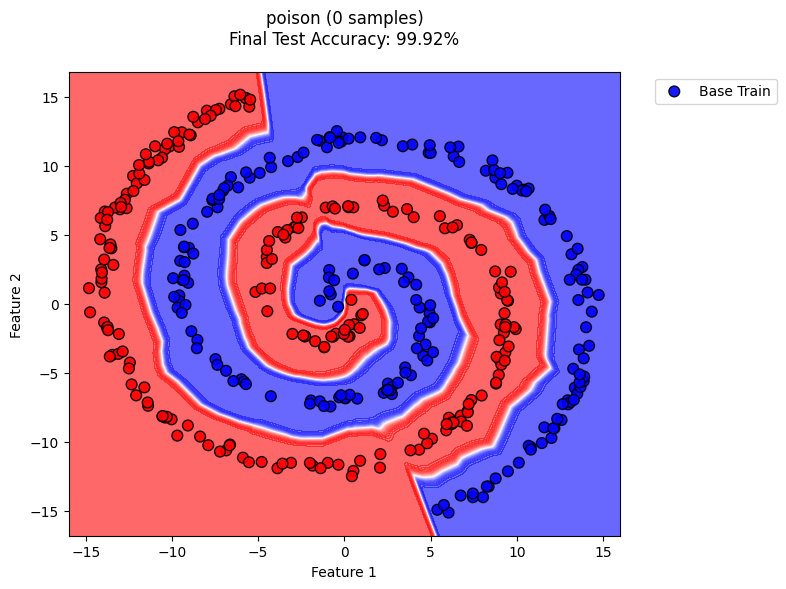

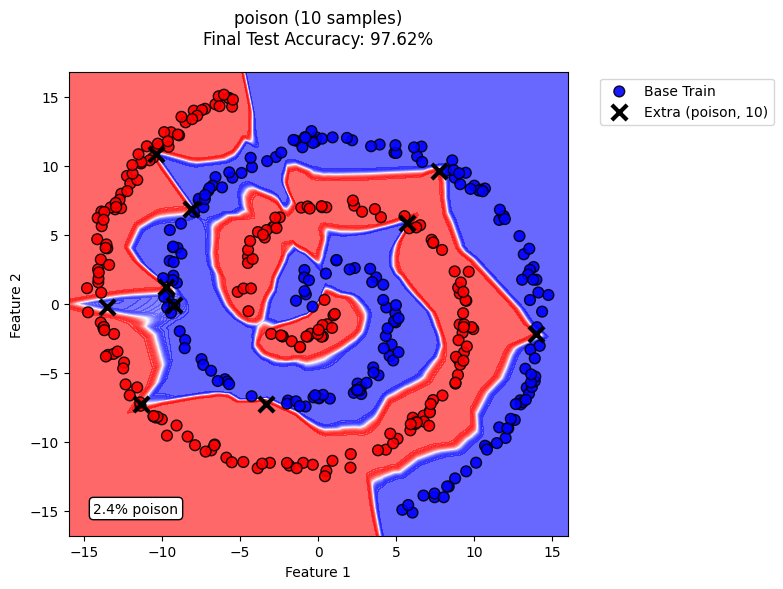

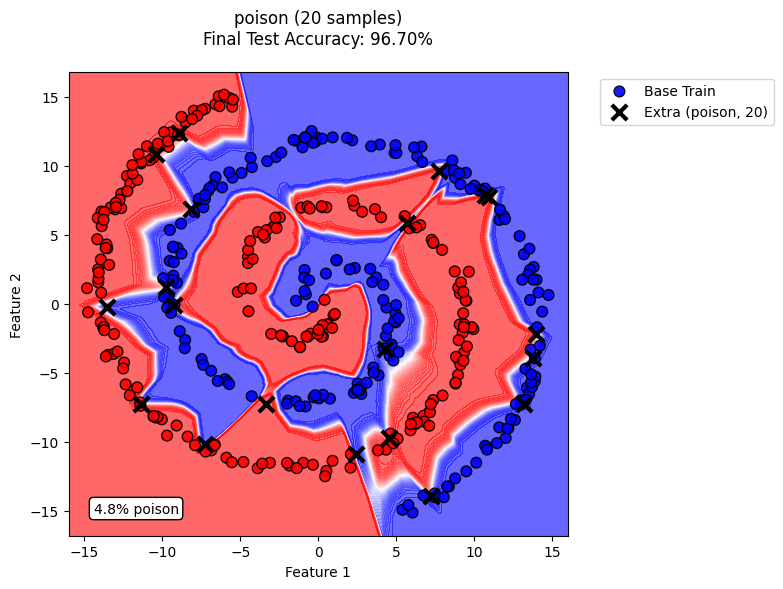

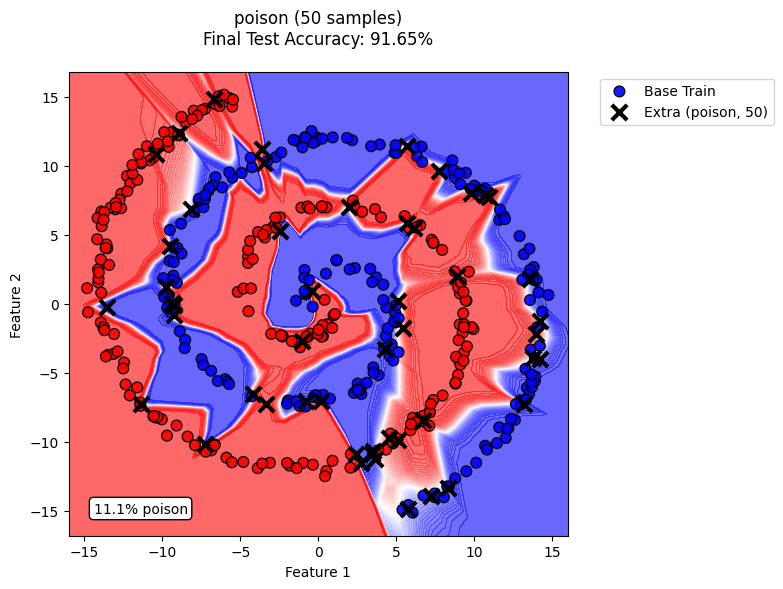

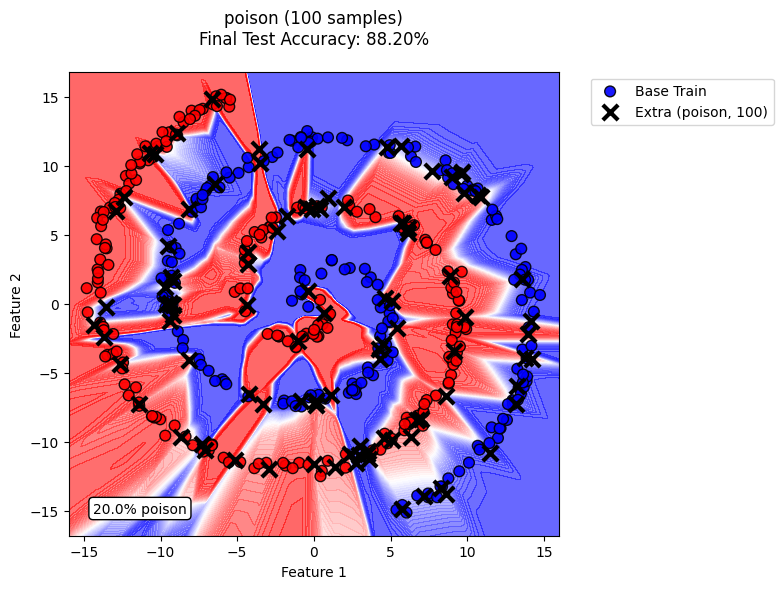

In [7]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [8]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_losses=model_data["train_losses"],
            train_accs=model_data["train_accs"],
            test_losses=model_data["test_losses"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
